In [1]:
import os

import numpy as np
from netCDF4 import Dataset
import pandas as pd

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#pd.set_option('display.max_rows', None)

In [2]:
hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi_qonly_noerradj"
hofx_suffix = "conv_q_01.nc4"

group = "Observation"
varname = "specificHumidity"

In [3]:
def read_hofx_file(file_dir, filename_suffix, groupname, flag):
    # List all files in the directory that match the pattern pe{proc}.conv_q_01.nc4
    hofx_files = [os.path.join(file_dir, f) for f in os.listdir(file_dir) if f.endswith(filename_suffix)]

    all_latitudes = np.empty((0,))
    all_longitudes = np.empty((0,))
    all_pressures = np.empty((0,))
    all_values = np.empty((0,))
    have_data = False

    # Loop over each file and extract the required data
    for index, file in enumerate(hofx_files):
        with Dataset(file, "r") as nc_file:
            # Read the relevant variables
            try:
                flags = nc_file.variables["Analysis_Use_Flag"][:]
                lats = nc_file.variables['Latitude'][:][flags == flag]
                lons = nc_file.variables['Longitude'][:][flags == flag]
                press = nc_file.variables['Pressure'][:][flags == flag]
                values = nc_file.variables[groupname][:][flags == flag]
                if "Errinv" in groupname:
                    values = 1.0 / values
                if "conv_q" in filename_suffix :
                    values = values * 1000
                have_data = True
            except:
                have_data = False
                print(f"No data in file: {file}")

        if have_data:
            all_latitudes = np.append(all_latitudes, lats)
            all_longitudes = np.append(all_longitudes, lons)
            all_pressures = np.append(all_pressures, press)
            all_values = np.append(all_values, values)

    return all_latitudes, all_longitudes, all_pressures, all_values

In [4]:
def find_duplicates(lats, lons, press, values):

    data = np.column_stack((lats, lons, press, values))
    df = pd.DataFrame(data, columns=['lats', 'lons', 'press', 'values'])
    #print(df)

    # Group by 'lats' and 'lons' and aggregate 'values' into lists
    grouped = df.groupby(['lats', 'lons'])['values'].agg(list).reset_index()
    
    # Expand the lists in 'values' into separate columns
    expanded = pd.DataFrame(grouped['values'].tolist())
    
    # Combine the 'lats' and 'lons' columns with the expanded values
    result = pd.concat([grouped[['lats', 'lons']], expanded], axis=1)

    grouped = df.groupby(['lats', 'lons']).size().reset_index(name='values')
    grouped = grouped[grouped['values'] != 1].to_numpy()

    return grouped[:,0], grouped[:,1], grouped[:,2], result

In [5]:
def variable_scatter(lons, lats, values, colormap="terrain", markersize=1.0, alpha=1.0,
                     minval=None, maxval=None, area=[-140, -50, 20, 60], clon=-95, clat=40,
                     system=None, varname=None, vartype=None, counts=False):
    fig = plt.figure(figsize=(20, 16))

    cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                       standard_parallels=(clat-5, clat+5))
    #projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    ax = plt.axes(projection=projection)
    ax.set_extent(area, crs=ccrs.PlateCarree())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, zorder=0)
    
    # Add coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
    ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Add country borders
    countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
    ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)
    
    # Add state lines
    states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

    sc = ax.scatter(lons, lats, c=values, cmap=colormap, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), s=markersize, alpha=alpha)

    # Calculate the min and max of the values array
    n_obs = values.shape[0]
    min_value = np.min(values)
    max_value = np.max(values)
    mean_value = np.mean(values)
    stdev_value = np.std(values)

    # Add text for the min and max values in the bottom left corner of the map
    text_str = f"Number of Obs: {n_obs:4}\nMin Value: {min_value:.4f} \
                 \nMax Value: {max_value:.4f}\nMean Value: {mean_value:.4f} \
                 \nStandard Deviation: {stdev_value:.4f}"
    ax.text(area[0] + 1, area[2] - 1, text_str, transform=ccrs.PlateCarree(),
            fontsize=18, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add a colorbar at the bottom
    if counts:
        cblabel = system + " " + varname + " duplicates"
    else:
        if "Errinv" in vartype:
            cblabel = system + " " + varname + " 1/" + vartype
        else:
            cblabel = system + " " + varname + " " + vartype
    cbar = plt.colorbar(sc, label=cblabel, orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)

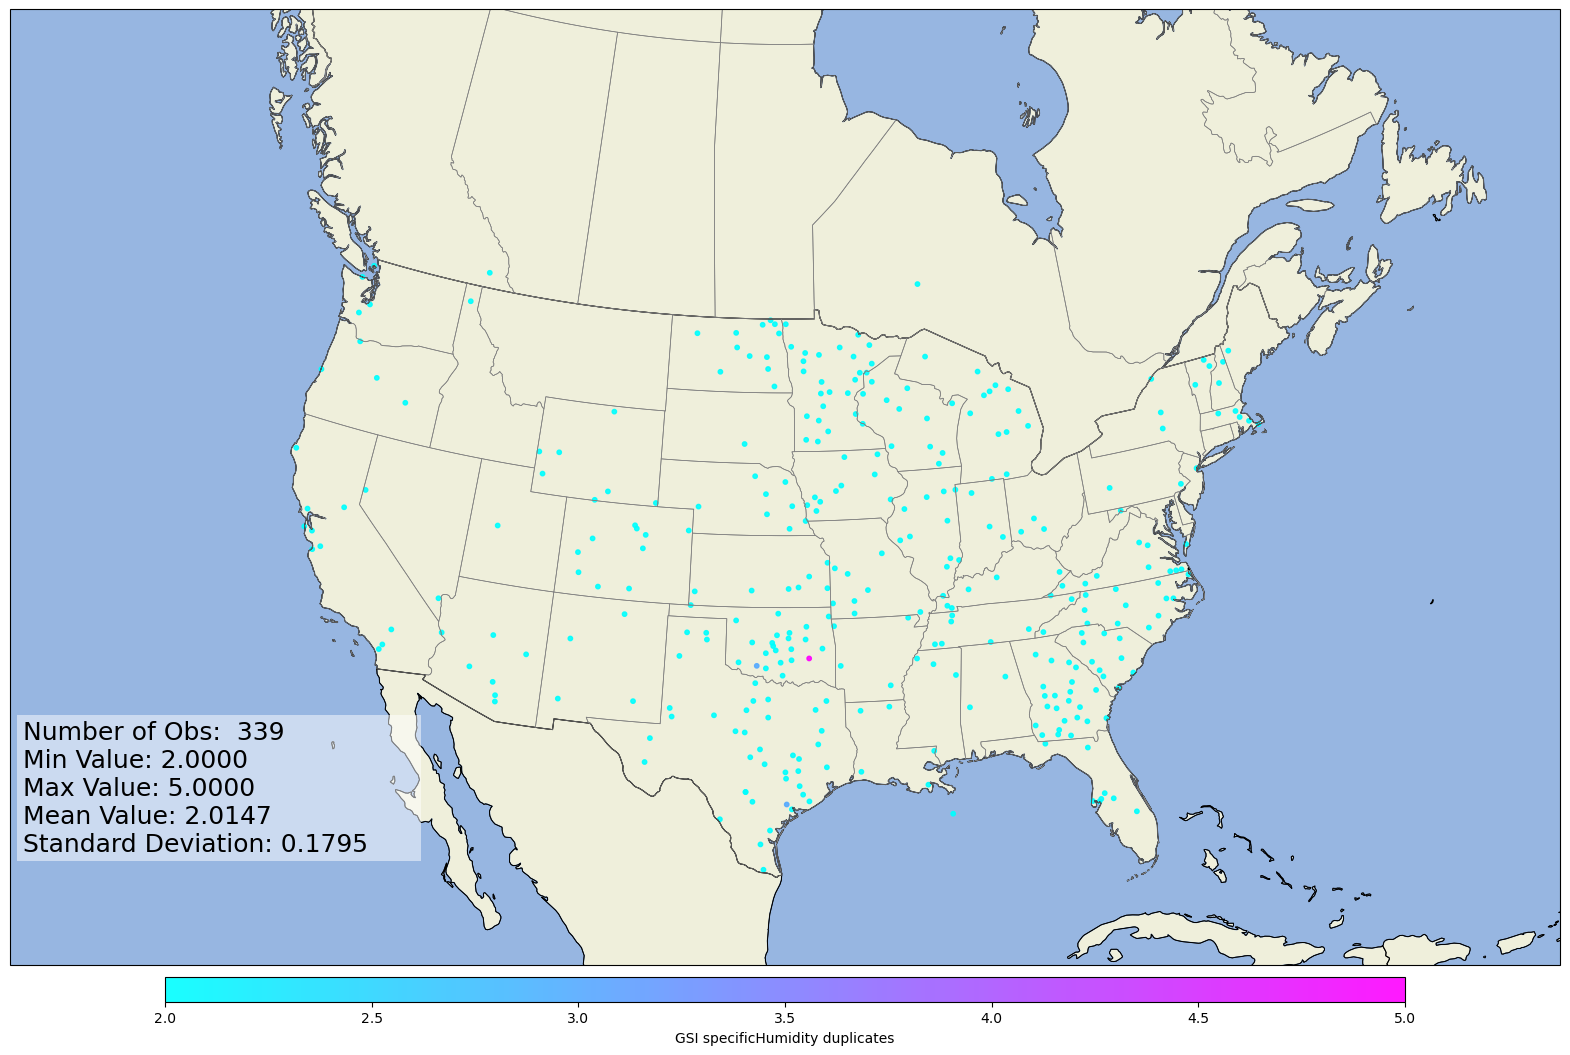

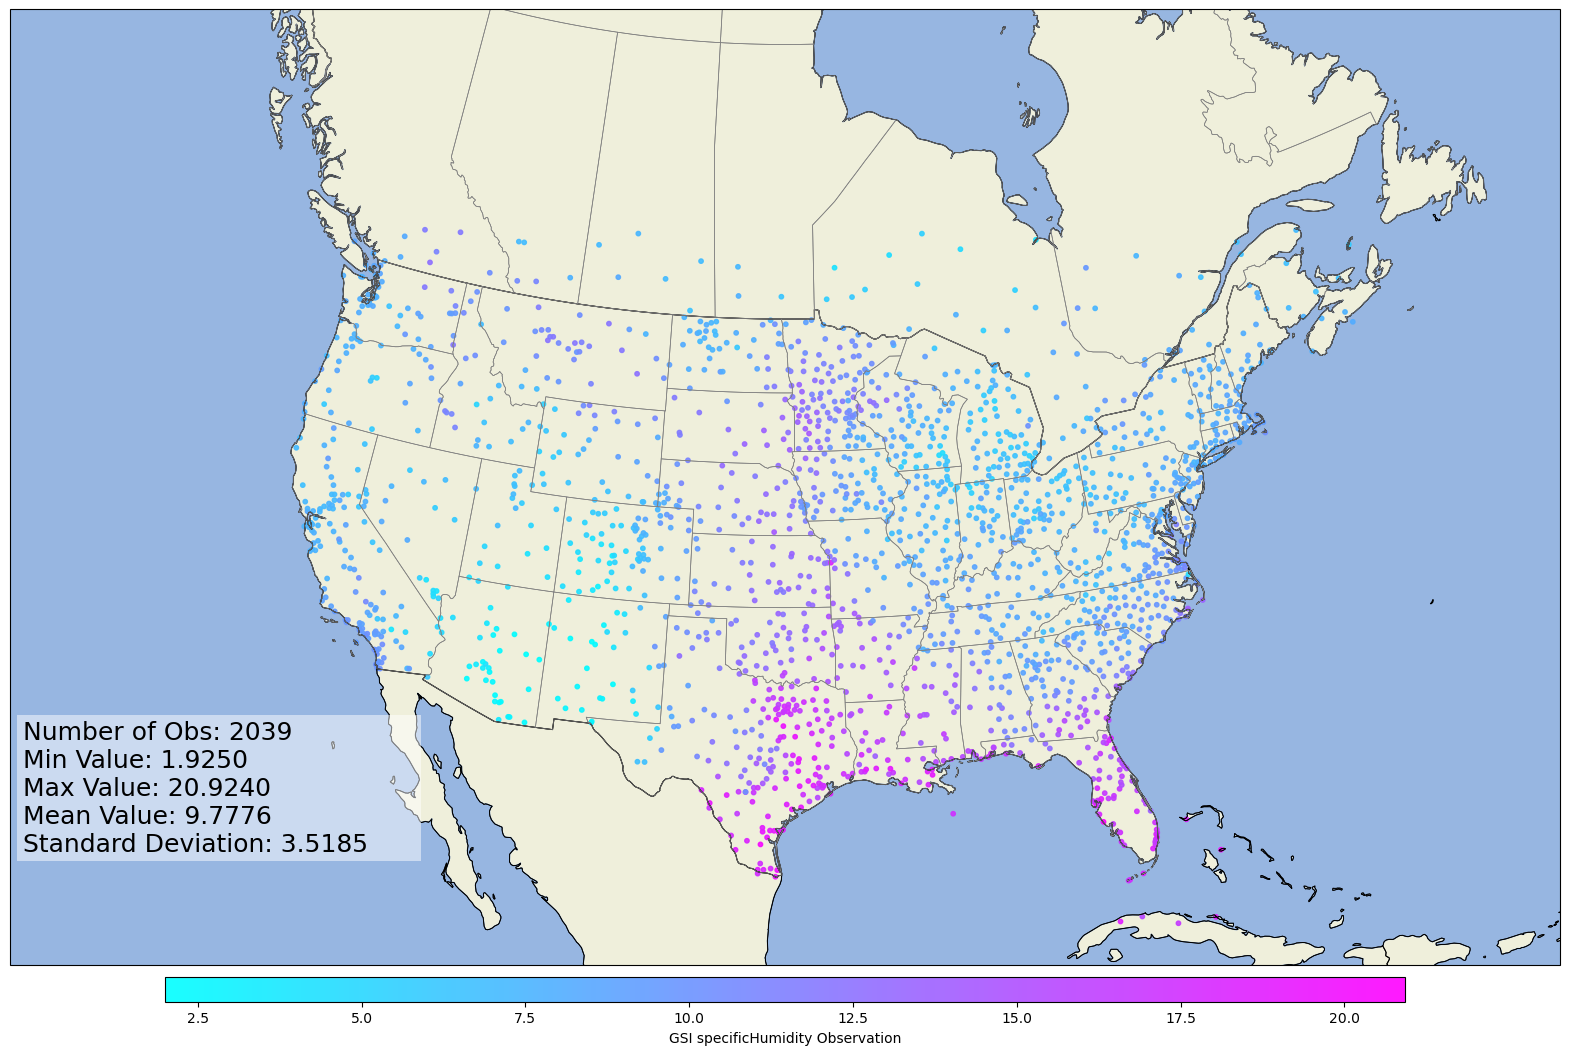

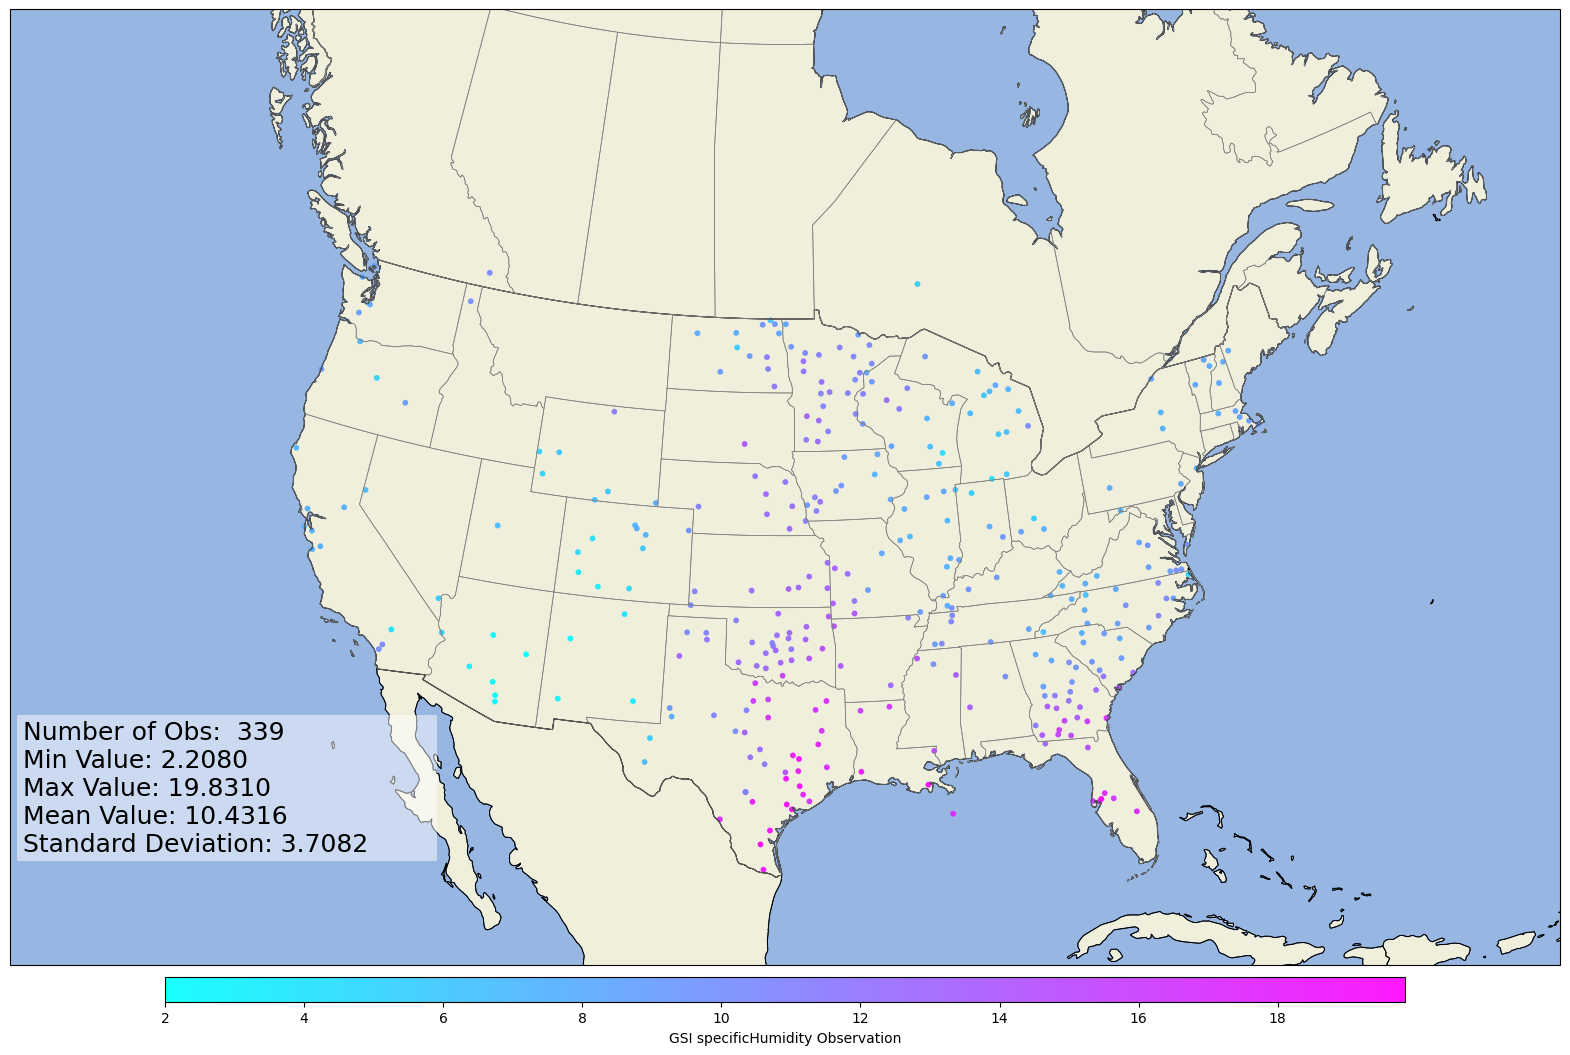

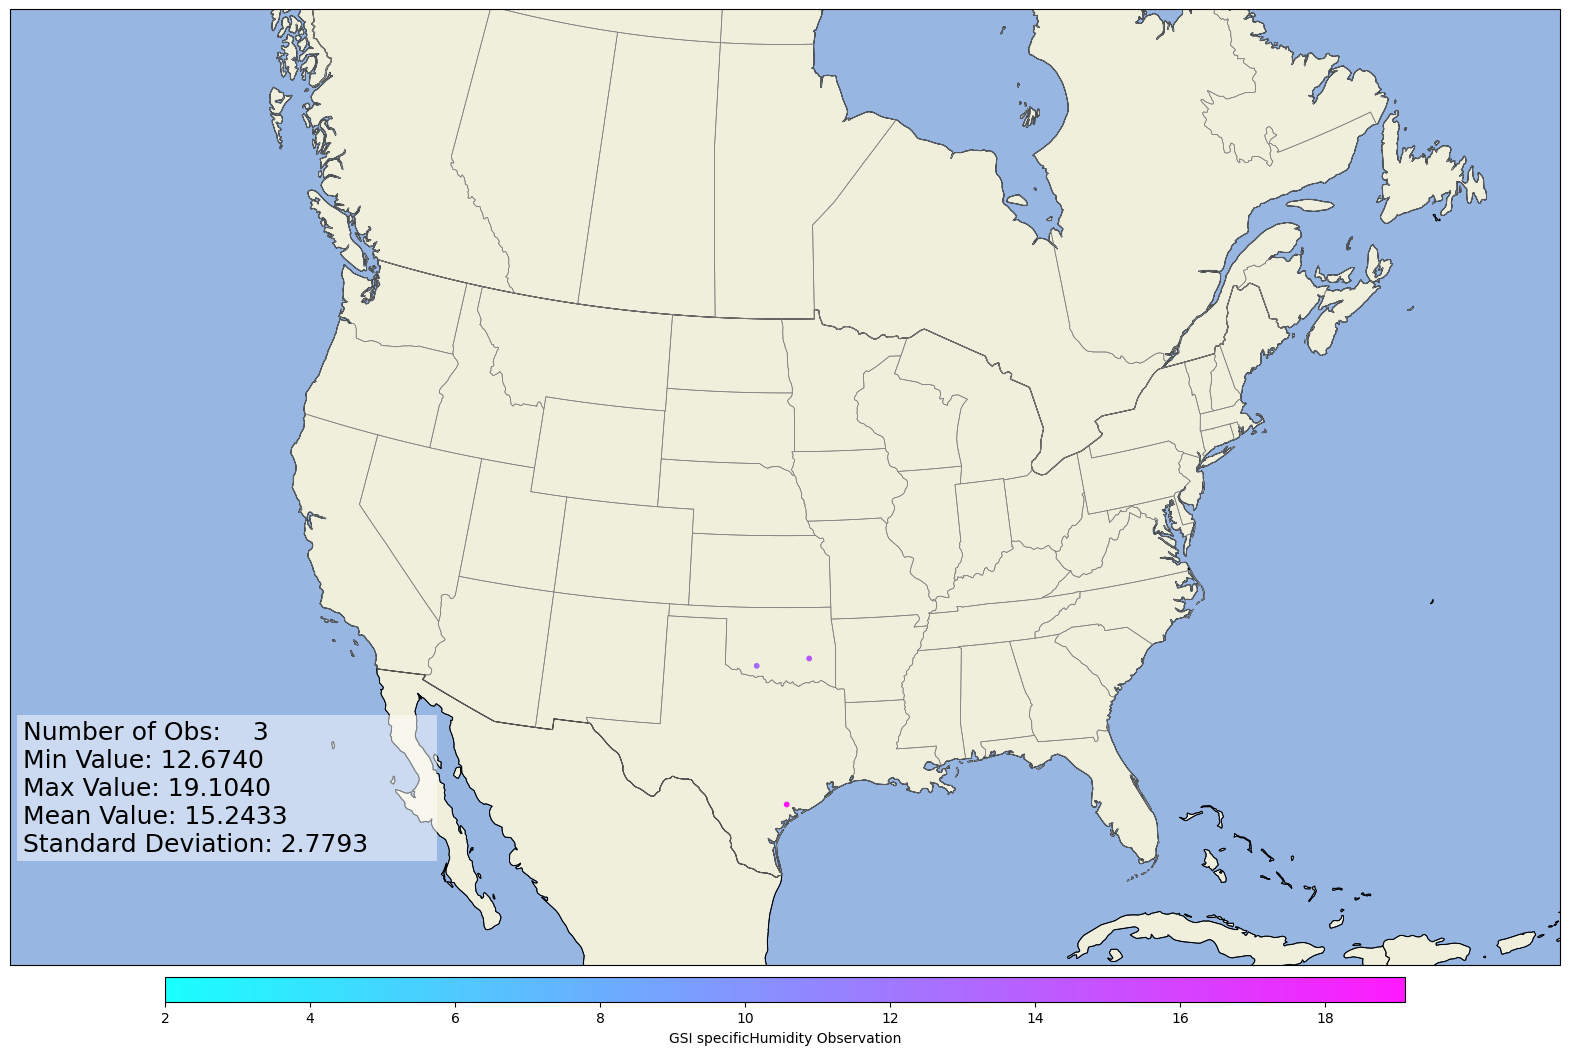

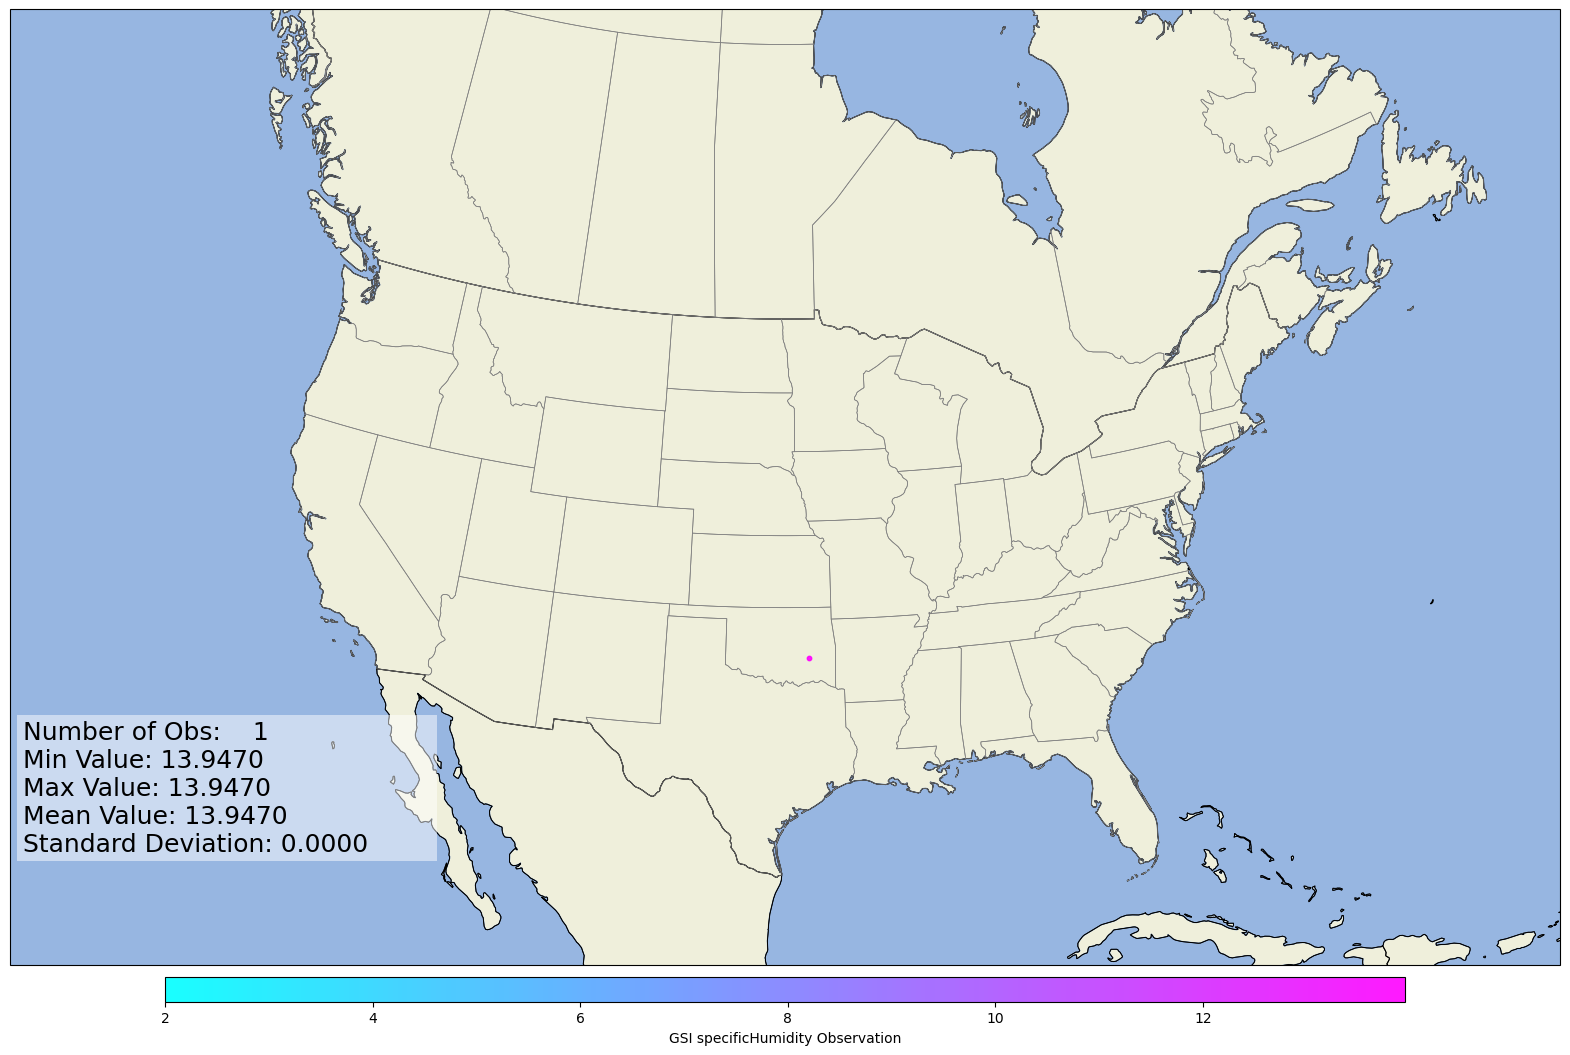

In [8]:
if __name__ == "__main__":
    
    lats, lons, press, values = read_hofx_file(hofx_dir, hofx_suffix, group, flag=1)

    maxlat = 58
    minlat = 22
    maxlon = -63
    minlon = -131
    maxval = 3
    minval = -3

    dup_lats, dup_lons, dup_nums, dup_df = find_duplicates(lats, lons, press, values)

    if len(dup_lats) > 0:
        variable_scatter(dup_lons, dup_lats, dup_nums, "cool", markersize=10, alpha=0.9, minval=2,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="GSI", varname=varname, vartype=group, counts=True)

    
    ncol = dup_df.shape[1] - 3
    for icol in range(ncol):
        filtered_df = dup_df[~dup_df[icol].isna()]
        lons = filtered_df["lons"].to_numpy()
        lats = filtered_df["lats"].to_numpy()
        vals = filtered_df[icol].to_numpy()
        variable_scatter(lons, lats, vals, "cool", markersize=10, alpha=0.9, minval=2,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="GSI", varname=varname, vartype=group)